In [176]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch


class UNet(nn.Module):
    # a baby U-net style model
    def __init__(self):
        super(UNet, self).__init__()
        #We have grayscaled our images, so we only have 1 channel
        self.dconv = nn.Conv2d(1, 1, 1,padding=0)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.uconv1 = nn.ConvTranspose2d(1, 1, 3,stride=2,output_padding=1)


    def forward(self, x): #input is 128x128
        #Go down
        x= self.dconv(x) #output is 126x126
        #x = F.relu(x)
        #x= self.dconv(x) #output is 126x126
        #x = F.relu(x)
        #x= self.dconv(x) #output is 126x126
        #x = F.relu(x)
        #x= self.dconv(x) #output is 126x126
        #x = F.relu(x)
        #x = self.pool(x) #output is 64*64
        # go back up
       # x = self.uconv1(x) #now we're back to 128
        return x


net = UNet()

In [177]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



In [178]:
# Define the Binary Cross Entropy loss function
class BCELoss2d(nn.Module):
    """
    Code taken from:
    https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37208
    """

    def __init__(self, weight=None, size_average=True):
        super(BCELoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, logits, targets):
        m = nn.Softmax2d()
        probs = F.sigmoid(logits)
        #probs = m(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        return self.bce_loss(probs_flat, targets_flat)
criterion = BCELoss2d()

In [179]:
#glob all of the training images and associated masks
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import img_as_float
train_img_list = sorted(glob.glob("/home/jag20/540/project/proc_train_img/*/images/*"))
train_img_masks = sorted(glob.glob("/home/jag20/540/project/proc_train_img/*/masks/*"))
m = len(train_img_list)
features = torch.Tensor(m,1,128,128) #each image segment is 128x128 gray scale
targets  = torch.Tensor(m,1,128,128)
for img_index in range(m):
    img_path  = train_img_list[img_index]
    img = torch.from_numpy(img_as_float(imread(img_path))).float()
    features[img_index,0,:,:] = img
    mask_path  = train_img_masks[img_index]
    mask = torch.from_numpy(imread(mask_path)).long()
    targets[img_index,0,:,:] = mask
    
#features = torch.from_numpy(features) #convert to pytorch tensors
#targets = torch.from_numpy(targets)


In [180]:
import torch.utils.data as data_utils

#load dataset and convert to pytorch tensordata for passing to the neural network
train = data_utils.TensorDataset(features, targets)
trainloader = data_utils.DataLoader(train, batch_size=5, shuffle=True)

In [181]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [182]:
a = iter(trainloader)

[[0.10396613 0.10396538 0.10396613 ... 0.10397613 0.10396922 0.10396769]
 [0.10396538 0.10396538 0.10396538 ... 0.10396613 0.10396691 0.10396613]
 [0.10396538 0.1039646  0.10396538 ... 0.10396538 0.1039646  0.1039646 ]
 ...
 [0.10396538 0.10396613 0.10396538 ... 0.10396382 0.10396307 0.1039646 ]
 [0.10396538 0.10396538 0.10396538 ... 0.10396382 0.10396382 0.10396382]
 [0.10396538 0.10396691 0.10396613 ... 0.10396307 0.1039646  0.10396382]]


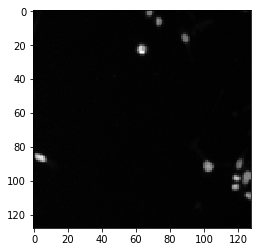

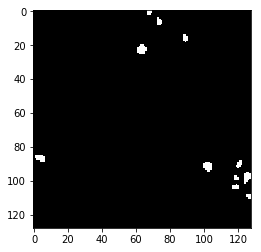

In [188]:
from skimage import color, filters, measure
images, labels = next(a)
#m = F.sigmoid()
test=F.sigmoid(net(Variable(images[0][None,:,:,:])))
test=test[0,0,:,:].data.numpy()
print(test)
#val = filters.threshold_otsu(test)
#nuc_mask = test > val
plt.imshow(test,cmap='gray')
plt.show()
#print(np.amax(labels[0,0,:,:]))
plt.imshow(labels[0,0,:,:],cmap='gray')
plt.show()


Let's see how we do on some of the test images

In [317]:
#glob all of the test images
test_img_list = sorted(glob.glob("/home/jag20/540/project/test/*/images/*"))
print(len(test_img_list))

65


In [364]:
def rle_encoding(dots): #this function modified from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(i) for i in run_lengths]

/home/jag20/540/project/test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/images/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png
0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
0.11927157043828629


/home/jag20/anaconda2/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


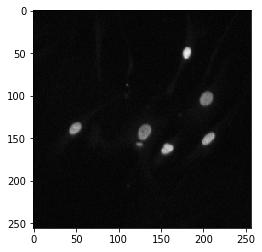

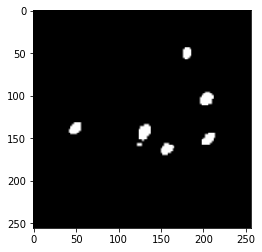

/home/jag20/540/project/test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/images/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
0.11928042760700919


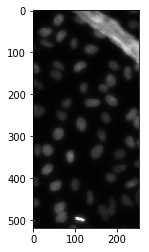

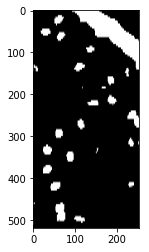

/home/jag20/540/project/test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/images/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
0.1192782363796141


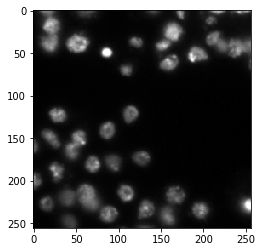

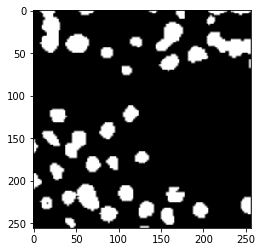

/home/jag20/540/project/test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/images/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925.png
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
0.11927675719198305


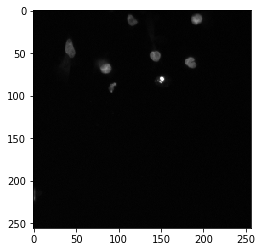

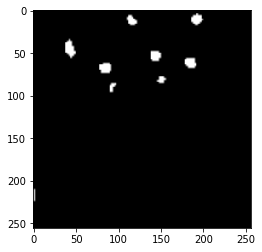

/home/jag20/540/project/test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/images/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6.png
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
0.11928512896702159


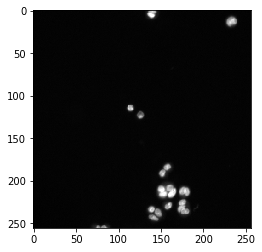

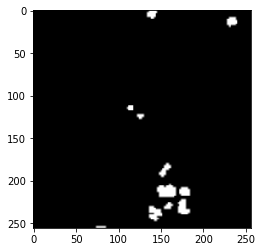

/home/jag20/540/project/test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/images/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466.png
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466
0.11929581375443377


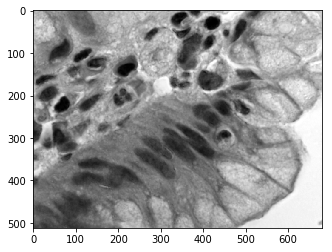

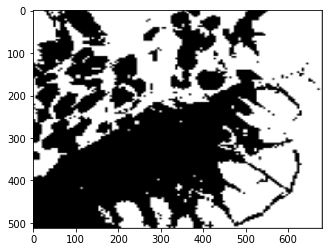

/home/jag20/540/project/test/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/images/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c.png
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
0.1192729443864664


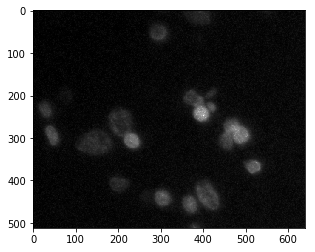

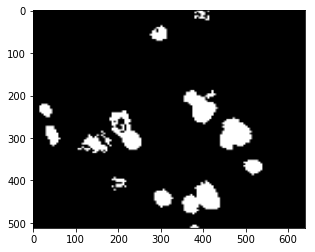

/home/jag20/540/project/test/17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff/images/17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff.png
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff
0.11929920932743698


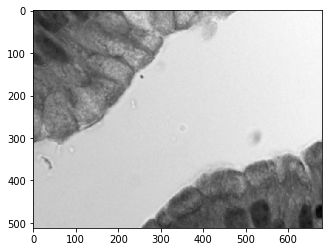

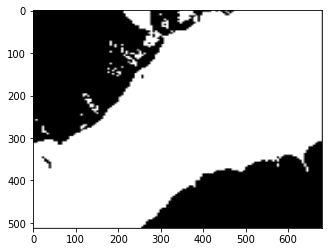

/home/jag20/540/project/test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/images/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b.png
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b
0.1192705545690842


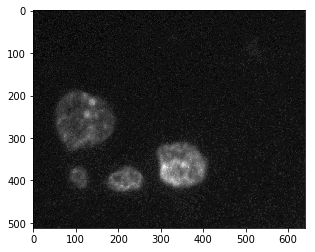

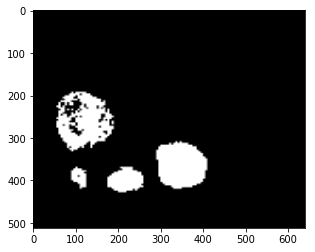

/home/jag20/540/project/test/191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829/images/191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829.png
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829
0.11927254270995036


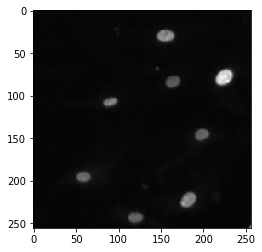

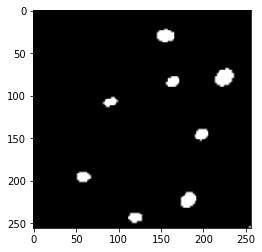

/home/jag20/540/project/test/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/images/1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a.png
1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a
0.11927602213108912


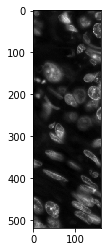

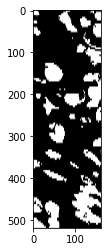

/home/jag20/540/project/test/1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e/images/1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e.png
1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e
0.11927207345433999


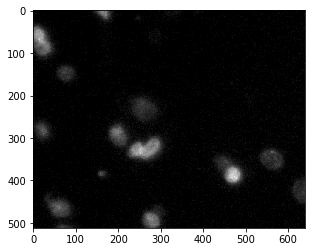

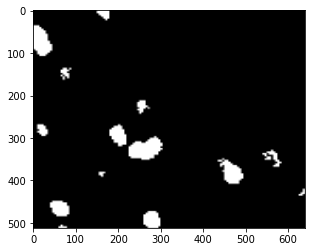

/home/jag20/540/project/test/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1/images/1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1.png
1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1
0.11930266760464292


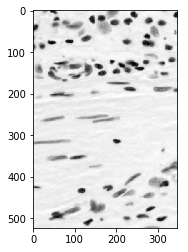

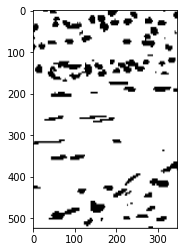

/home/jag20/540/project/test/1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c/images/1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c.png
1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c
0.11928266231552698


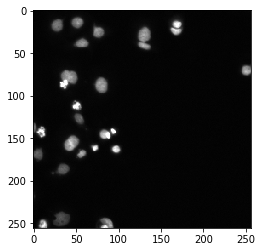

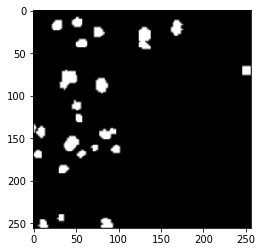

/home/jag20/540/project/test/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4/images/259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4.png
259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4
0.11929756448080298


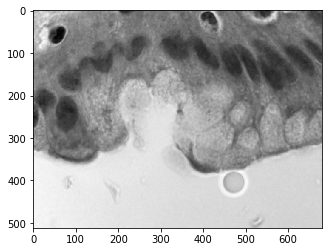

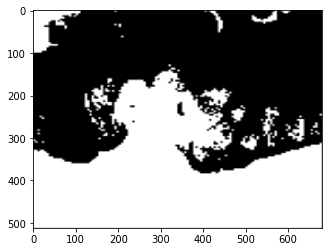

/home/jag20/540/project/test/295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549/images/295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549.png
295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549
0.11927960976026952


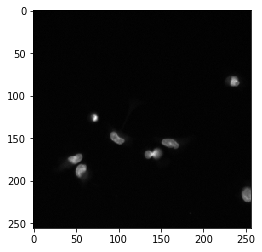

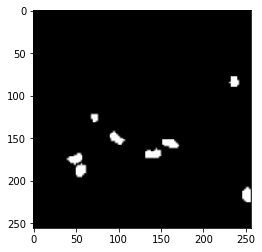

/home/jag20/540/project/test/31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a/images/31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a.png
31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a
0.1192820092983311


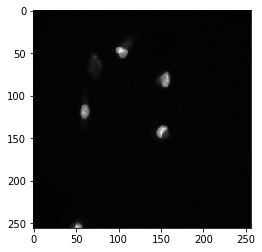

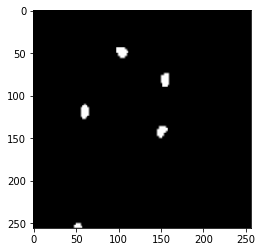

/home/jag20/540/project/test/336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523/images/336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523.png
336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523
0.11928444278601091


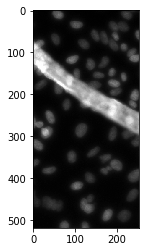

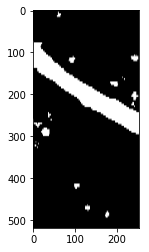

/home/jag20/540/project/test/38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f/images/38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f.png
38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f
0.11927302123513073


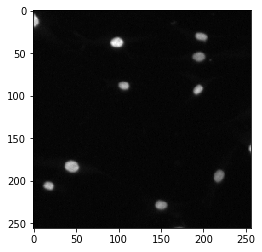

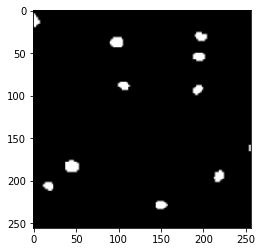

/home/jag20/540/project/test/3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26/images/3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26.png
3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26
0.11930154959554784


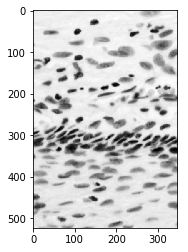

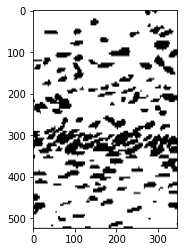

/home/jag20/540/project/test/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580/images/432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580.png
432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580
0.11928328294015955


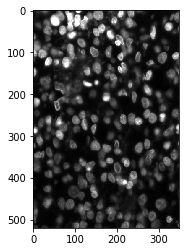

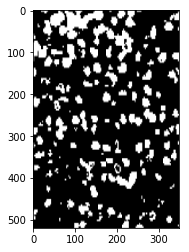

/home/jag20/540/project/test/43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af/images/43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af.png
43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af
0.1192870991944801


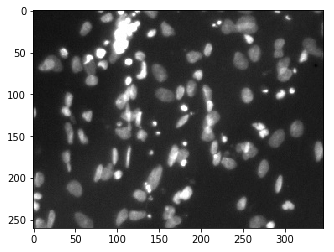

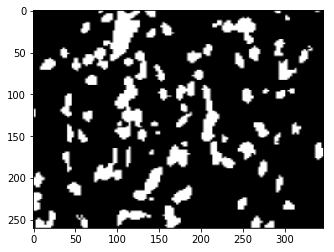

/home/jag20/540/project/test/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078/images/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078.png
44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078
0.11929844025871716


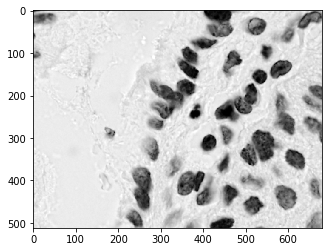

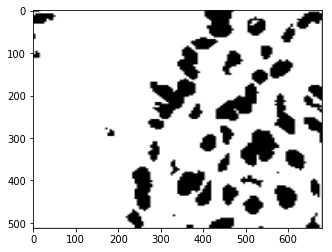

/home/jag20/540/project/test/4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2/images/4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2.png
4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2
0.11928370042005554


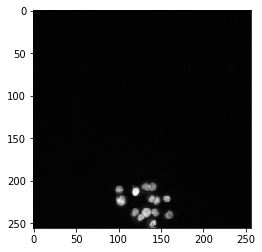

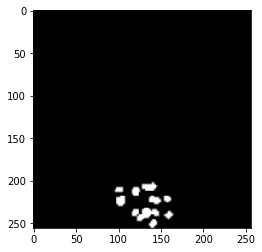

/home/jag20/540/project/test/472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71/images/472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71.png
472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71
0.11929172188683879


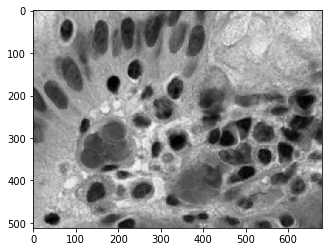

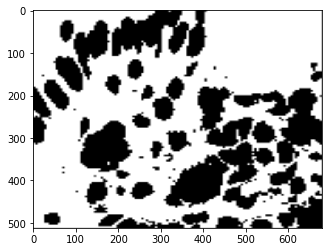

/home/jag20/540/project/test/4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee/images/4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee.png
4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee
0.11927601395291276


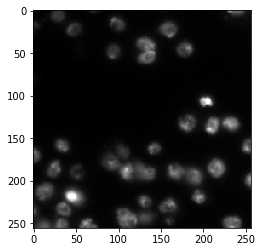

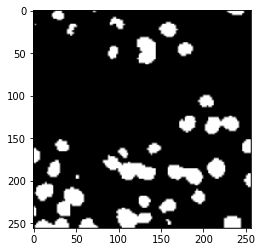

/home/jag20/540/project/test/4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac/images/4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac.png
4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac
0.1192704606364714


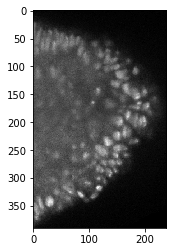

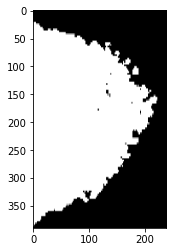

/home/jag20/540/project/test/505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81/images/505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81.png
505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81
0.11927179507620167


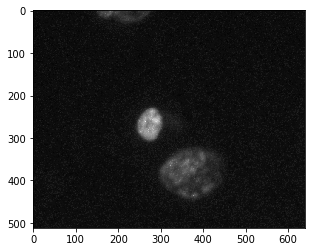

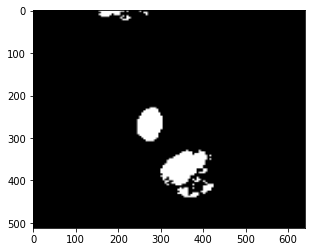

/home/jag20/540/project/test/519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0/images/519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0.png
519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0
0.11927255967748351


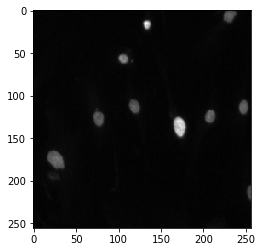

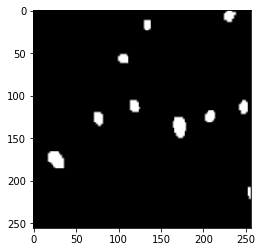

/home/jag20/540/project/test/51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b/images/51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b.png
51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b
0.11928147458820604


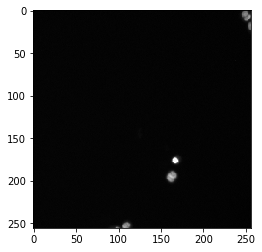

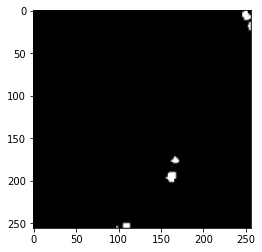

/home/jag20/540/project/test/52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde/images/52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde.png
52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde
0.11928852889104746


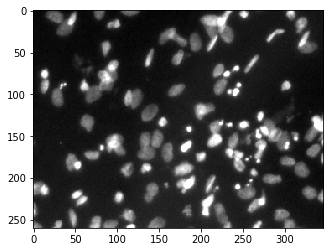

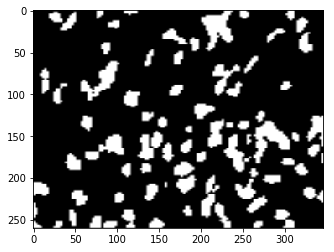

/home/jag20/540/project/test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4/images/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4.png
53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4
0.11927319638198242


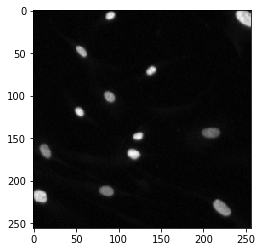

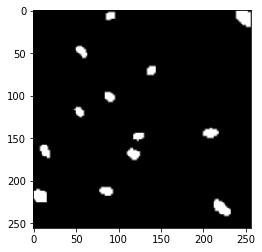

/home/jag20/540/project/test/550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18/images/550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18.png
550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18
0.11928068780980539


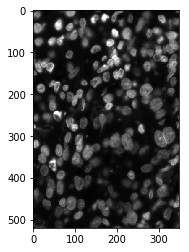

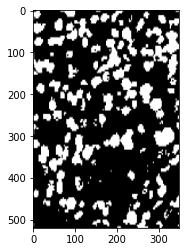

/home/jag20/540/project/test/5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7/images/5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7.png
5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7
0.11927446284971666


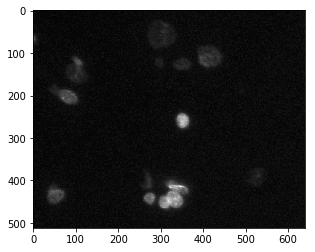

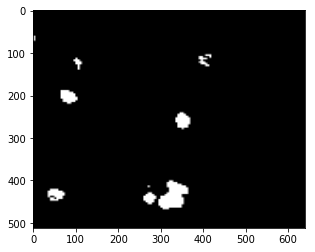

/home/jag20/540/project/test/648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9/images/648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9.png
648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9
0.11928076902404428


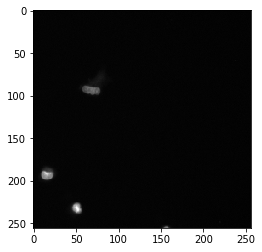

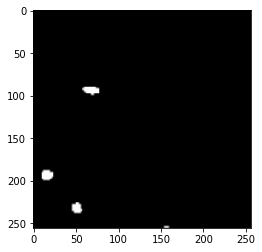

/home/jag20/540/project/test/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/images/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808.png
697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808
0.11928005472873338


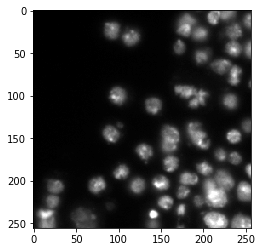

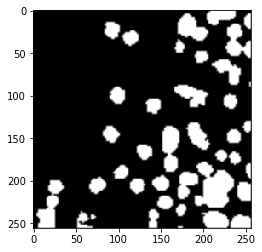

/home/jag20/540/project/test/699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68/images/699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68.png
699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68
0.11928967114363331


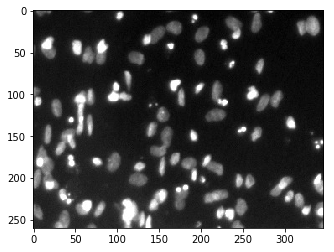

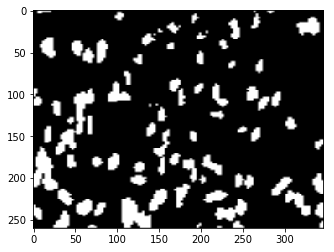

/home/jag20/540/project/test/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d/images/78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d.png
78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d
0.11927514903072733


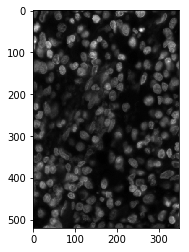

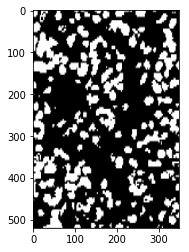

/home/jag20/540/project/test/7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04/images/7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04.png
7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04
0.11927417971310206


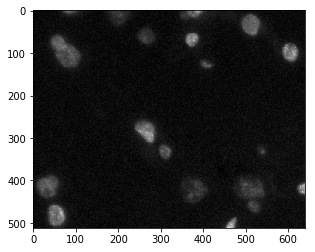

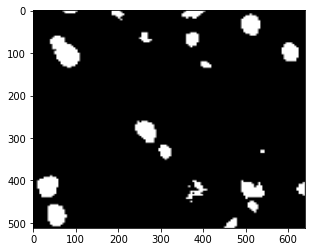

/home/jag20/540/project/test/7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af/images/7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af.png
7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af
0.11927705857669935


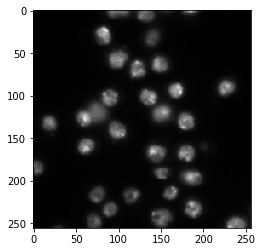

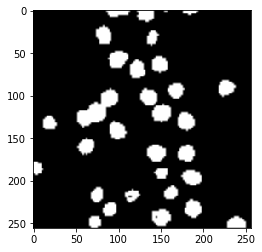

/home/jag20/540/project/test/8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b/images/8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b.png
8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b
0.11927477958670352


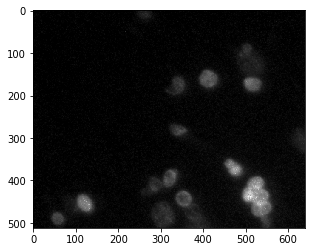

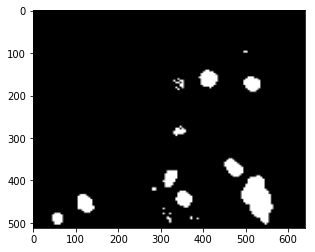

/home/jag20/540/project/test/8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab/images/8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab.png
8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab
0.11928077071206644


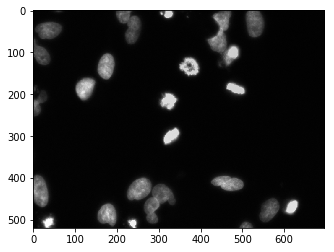

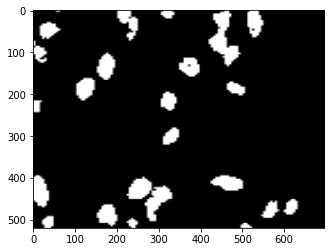

/home/jag20/540/project/test/912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406/images/912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406.png
912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406
0.11928208483732305


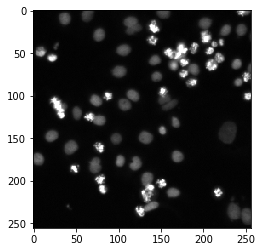

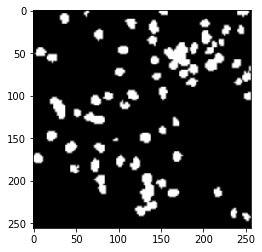

/home/jag20/540/project/test/9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2/images/9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2.png
9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2
0.11927319169626571


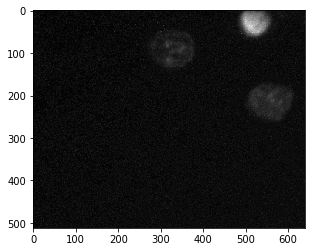

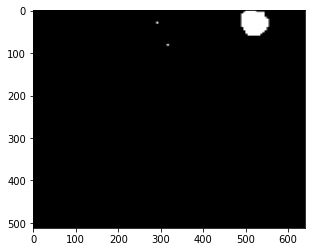

/home/jag20/540/project/test/9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab/images/9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab.png
9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab
0.11929985453025438


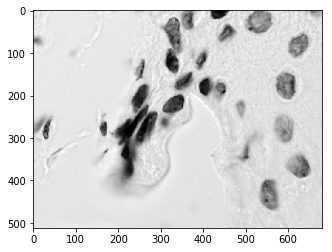

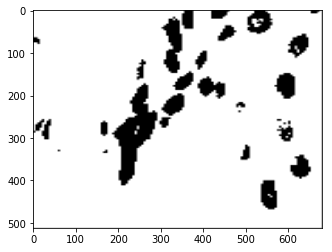

/home/jag20/540/project/test/a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f/images/a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f.png
a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f
0.1192732346826233


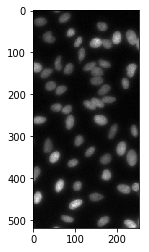

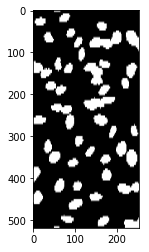

/home/jag20/540/project/test/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d/images/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d.png
a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d
0.1192828134080628


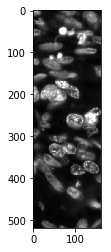

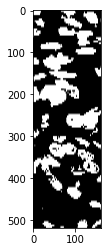

/home/jag20/540/project/test/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8/images/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8.png
ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8
0.11927241185912862


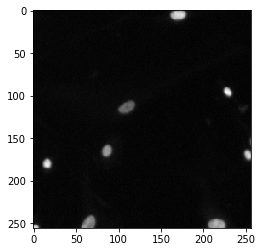

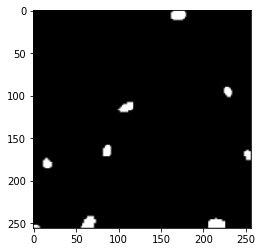

/home/jag20/540/project/test/ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e/images/ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e.png
ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e
0.11927999161707703


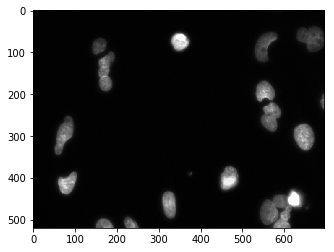

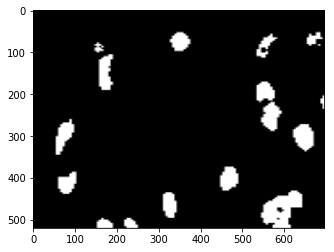

/home/jag20/540/project/test/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3/images/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3.png
b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3
0.11929945442534517


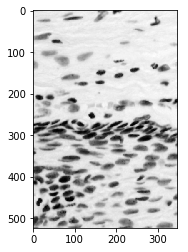

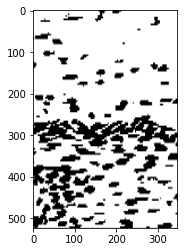

/home/jag20/540/project/test/bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d/images/bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d.png
bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d
0.11927854354144074


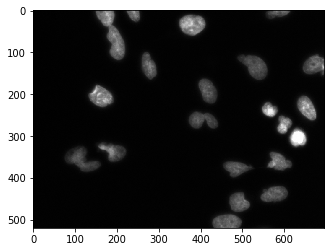

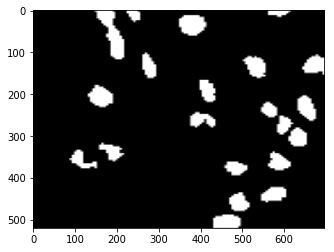

/home/jag20/540/project/test/c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb/images/c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb.png
c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb
0.11930107639636844


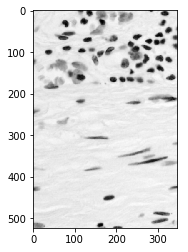

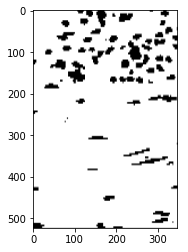

/home/jag20/540/project/test/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef/images/ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef.png
ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef
0.11927763026324101


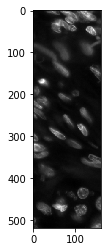

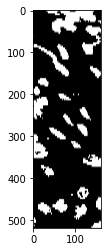

/home/jag20/540/project/test/d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d/images/d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d.png
d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d
0.11928199972317088


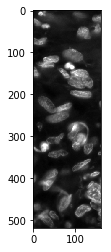

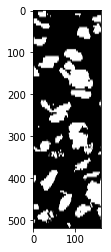

/home/jag20/540/project/test/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896/images/d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896.png
d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896
0.11927546956576407


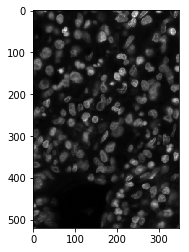

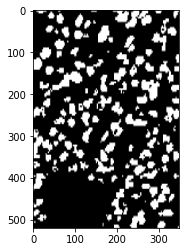

/home/jag20/540/project/test/d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b/images/d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b.png
d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b
0.11927904904587194


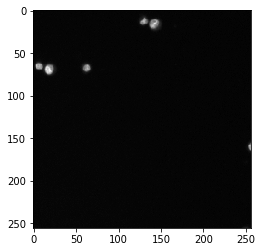

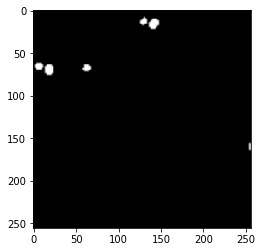

/home/jag20/540/project/test/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab/images/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab.png
da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab
0.11929763210355304


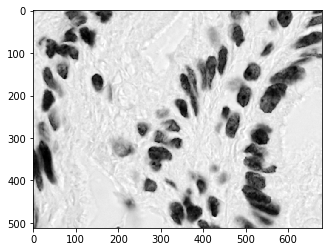

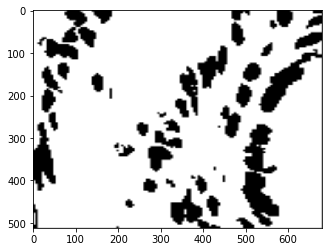

/home/jag20/540/project/test/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4/images/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4.png
dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4
0.11927295401983429


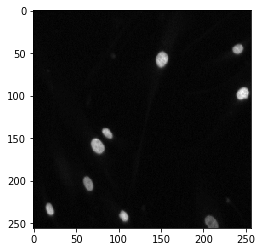

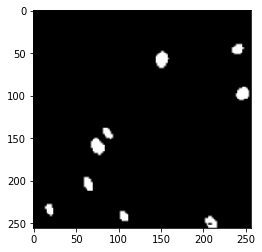

/home/jag20/540/project/test/df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8/images/df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8.png
df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8
0.11928366252686828


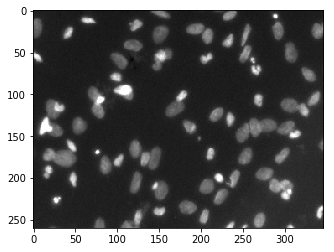

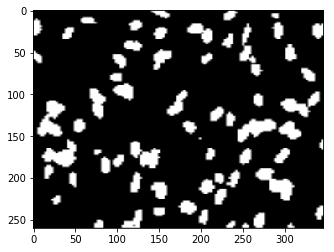

/home/jag20/540/project/test/e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258/images/e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258.png
e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258
0.11927240244403947


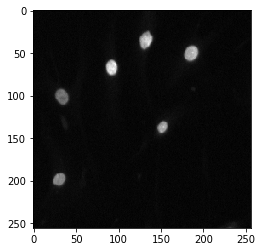

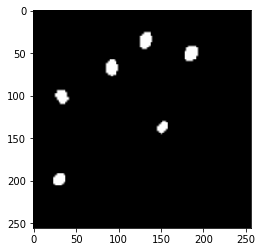

/home/jag20/540/project/test/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835/images/eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835.png
eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835
0.11928329382499214


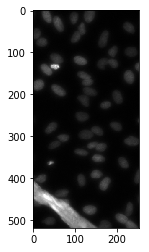

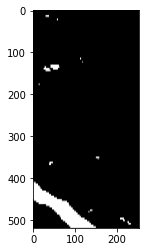

/home/jag20/540/project/test/f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4/images/f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4.png
f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4
0.11928015653393231


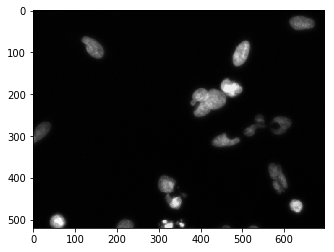

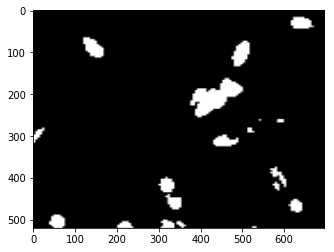

/home/jag20/540/project/test/f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb/images/f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb.png
f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb
0.11929702598717995


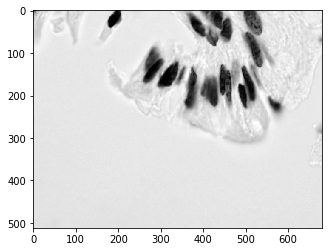

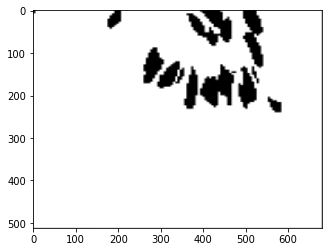

/home/jag20/540/project/test/fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3/images/fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3.png
fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3
0.11928147458820604


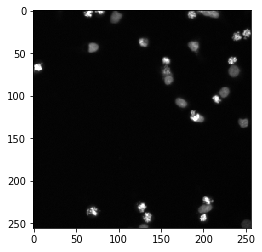

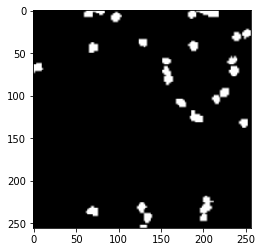

/home/jag20/540/project/test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/images/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f.png
fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f
0.11928343251929618


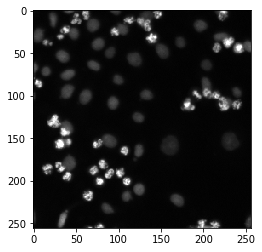

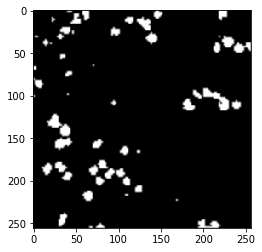

In [366]:
outsize = (128,128)
from skimage import color, filters, measure, util, transform, img_as_ubyte
import pandas as pd
data = pd.DataFrame(columns=["ImageId", "EncodedPixels"])
for i in range(len(test_img_list)):
    img_index = i
    img_path  = test_img_list[img_index]
    print(img_path)
    image_id = img_path.split("/")[-1].split('.')[0] #extract image id from path
    print(image_id)
    img_original =imread(img_path)
    img = color.rgb2gray(img_original)#read as black and white for simple thresholding segmentation
    img /= 255
    img_size = img.shape
    img_small = transform.resize(img,outsize,preserve_range=True)
 
    imgtest = Variable(torch.from_numpy(img_as_float(img_small[None,None,:,:])).float())
    test2 = F.sigmoid(net(imgtest))
    test=test2.data[0,0,:,:].numpy()
    val = filters.threshold_otsu(test) #For some reason, our network 
    #is not putting out any values > 0.5, so let's just threshold the predicted mask ... for now
    print(val)
    nuc_mask = test > val
    nuc_mask = transform.resize(nuc_mask,img_size,preserve_range=True)
    plt.imshow(img,cmap='gray')
    plt.show()
    plt.imshow(nuc_mask,cmap='gray')
    plt.show()
    nuc_labels = measure.label(nuc_mask,background=0) #label individual objects (nuclei)
    #Get RLE encoding for EACH nucleus in a given image
    for label in np.unique(nuc_labels)[1:]:
        nuc_pix = np.where(nuc_labels.T.flatten() == label)[0]  #np.where returns a tuple, 
       #so we have to take the first element, which is the array we want
 #       rle = rle_from_mask(nuc_pix)
        rle = rle_encoding(nuc_pix)
        #only keep rle's that are clearly not noise, e.g. more than a minimum number of pixels
        min_pix = 20 #Perhaps we could cross-validate the min_pix value on the training set.
        num_pix = sum([float(num) for num in rle[1::2]])
        if num_pix > min_pix:
            data = data.append({"ImageId":image_id, "EncodedPixels": " ".join(rle)}, ignore_index=True)
data.to_csv("submissionneural.csv", index=False)
